In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# !rm -rf acne_classification

In [ ]:
import os, tensorflow as tf
print("TF:", tf.__version__)
print("physical devices:", tf.config.list_physical_devices())
print("GPUs:", tf.config.list_physical_devices('GPU'))

import sys, os
print("Python exec:", sys.executable)

TF: 2.19.0
physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Python exec: /usr/bin/python3


In [ ]:
import sys, os
print("Python exec:", sys.executable)
import subprocess

# versi TF
try:
    import tensorflow as tf
    print("TF version:", tf.__version__)
    print("TF built with CUDA:", tf.test.is_built_with_cuda())
    print("Physical GPUs:", tf.config.list_physical_devices('GPU'))
except Exception as e:
    print("Import TF error:", repr(e))

# info pip & package location
print("\nPip show tensorflow:")
!"{sys.executable}" -m pip show tensorflow

# nvidia-smi
print("\nOutput nvidia-smi:")
!nvidia-smi

Python exec: /usr/bin/python3
TF version: 2.19.0
TF built with CUDA: True
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Pip show tensorflow:
Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras

Output nvidia-smi:
Fri Dec 19 13:57:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|---

In [ ]:
import sys
print("Python executable:", sys.executable)
print("Python version:", sys.version)

Python executable: /usr/bin/python3
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score
from tabulate import tabulate
import seaborn as sns
import yaml
import shutil
from pathlib import Path
from PIL import Image, ImageEnhance
import albumentations as A

# Ultralytics YOLOv8
!pip install ultralytics
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

# For Google Colab
from google.colab import drive
from IPython.display import display, Image as IPImage
from PIL import Image, ImageDraw, ImageFont

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
#from google.colab import files
import io
from datetime import datetime

In [ ]:
# from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class_mapping = {
    'ringan': 0,
    'sedang': 1
}

def enhance_image(image_path, save_path=None):
    img = cv2.imread(image_path)
    if img is None:
        return None

    img = cv2.fastNlMeansDenoisingColored(
        img, None,
        h=3, hColor=3,
        templateWindowSize=7,
        searchWindowSize=21
    )

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(
        clipLimit=1.2,
        tileGridSize=(8, 8)
    )
    l = clahe.apply(l)

    lab = cv2.merge([l, a, b])
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    blur = cv2.GaussianBlur(enhanced, (0, 0), sigmaX=0.8)
    enhanced = cv2.addWeighted(
        enhanced, 1.15,
        blur, -0.15,
        0
    )

    gamma = 1.02
    inv_gamma = 1.0 / gamma
    table = np.array([
        ((i / 255.0) ** inv_gamma) * 255
        for i in range(256)
    ]).astype("uint8")

    final = cv2.LUT(enhanced, table)

    if save_path:
        cv2.imwrite(save_path, final)

    return final

def create_classification_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),

        A.RandomBrightnessContrast(
            brightness_limit=0.08,
            contrast_limit=0.08,
            p=0.3
        ),

        A.GaussNoise(var_limit=(3, 8), p=0.1),

        A.Resize(224, 224)
    ])

def prepare_classification_dataset(base_path):
    for split in ['train', 'val']:
        for cls in class_mapping.keys():
            os.makedirs(f"{base_path}/{split}/{cls}", exist_ok=True)
    return base_path

def process_classification_dataset(
    src_root,
    dst_root,
    enhance=True,
    augment=True
):
    aug = create_classification_augmentation()

    for split in ['train', 'val']:
        for cls in class_mapping.keys():
            src_dir = os.path.join(src_root, split, cls)
            dst_dir = os.path.join(dst_root, split, cls)
            os.makedirs(dst_dir, exist_ok=True)

            images = [
                f for f in os.listdir(src_dir)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]

            for img_name in tqdm(images, desc=f"{split}/{cls}"):
                src_path = os.path.join(src_dir, img_name)
                dst_path = os.path.join(dst_dir, img_name)

                img = cv2.imread(src_path)
                if img is None:
                    continue

                # if enhance:
                #     img = enhance_image(src_path)

                if augment and split == 'train':
                    img = aug(image=img)['image']
                else:
                    img = cv2.resize(img, (224, 224))

                cv2.imwrite(dst_path, img)

def count_classification_images(base_dir):
    class_counts = {0: 0, 1: 0}

    for class_name, class_id in class_mapping.items():
        class_path = os.path.join(base_dir, class_name)

        if not os.path.exists(class_path):
            continue

        images = [
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        class_counts[class_id] = len(images)

    return class_counts

In [ ]:
base_path = '/content/acne_classification'
base_path = prepare_classification_dataset(base_path)

print("Preparing training and validation data...")
process_classification_dataset(
    src_root='/content/drive/MyDrive/Handover/Tingkat Keparahan Data dan Code/Data Severity',
    dst_root=base_path,
    enhance=True,
    augment=True
)

Preparing training and validation data...


/tmp/ipython-input-993426785.py:73: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(3, 8), p=0.1),


train/ringan:   0%|          | 0/16 [00:00<?, ?it/s]

train/sedang:   0%|          | 0/13 [00:00<?, ?it/s]

val/ringan:   0%|          | 0/4 [00:00<?, ?it/s]

val/sedang:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def plot_class_distribution(base_dir, title):
    counts = count_classification_images(base_dir)

    class_id_to_name = {v: k for k, v in class_mapping.items()}

    class_ids = sorted(counts.keys())
    classes = [class_id_to_name[i] for i in class_ids]
    values = [counts[i] for i in class_ids]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(classes, values, alpha=0.75)

    plt.xlabel('Kelas Jerawat')
    plt.ylabel('Jumlah Gambar')
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    for bar, count in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            str(count),
            ha='center',
            va='bottom',
            fontsize=10
        )

    plt.tight_layout()
    plt.show()


In [ ]:
print(class_mapping)

{'ringan': 0, 'sedang': 1}


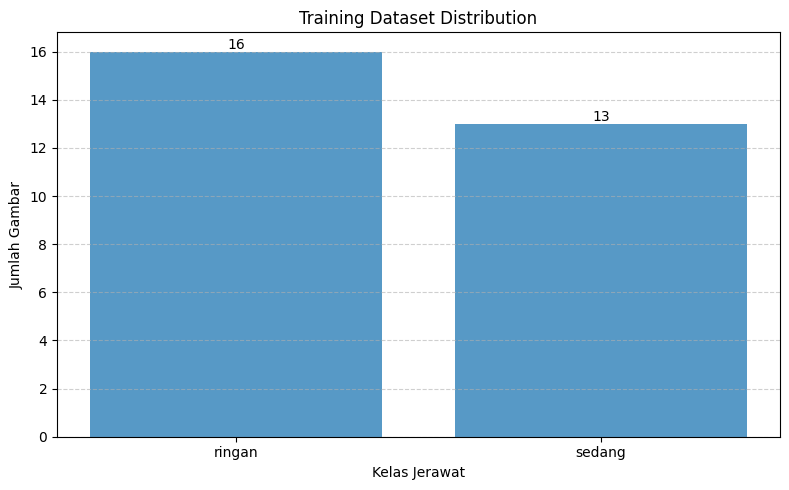

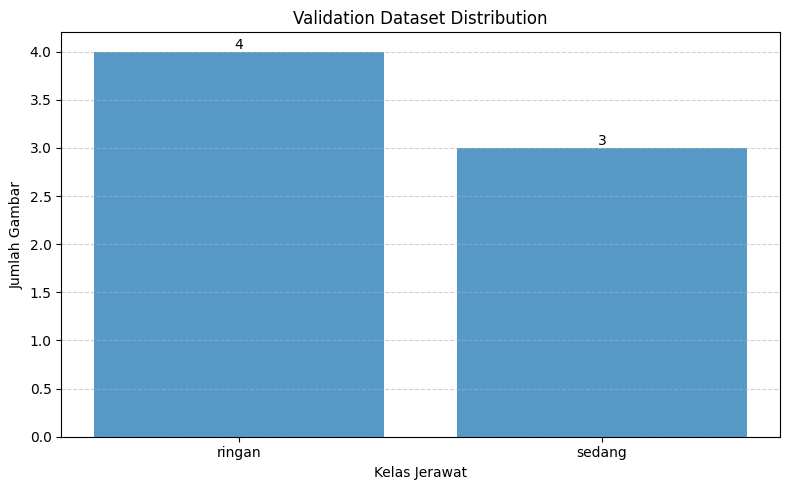

In [ ]:
plot_class_distribution(f'{base_path}/train', 'Training Dataset Distribution')
plot_class_distribution(f'{base_path}/val', 'Validation Dataset Distribution')

In [ ]:
def visualize_classification_samples(
    base_dir,
    num_samples=6,
    title="Dataset Samples (Classification)"
):

    samples = []

    for class_name, class_id in class_mapping.items():
        class_path = os.path.join(base_dir, class_name)

        if not os.path.exists(class_path):
            print(f"Folder tidak ditemukan: {class_path}")
            continue

        images = [
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        for img in images:
            samples.append((class_name, os.path.join(class_path, img)))

    if len(samples) == 0:
        print("Tidak ada gambar ditemukan.")
        return

    selected = random.sample(samples, min(num_samples, len(samples)))

    cols = 3
    rows = (len(selected) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for idx, (class_name, img_path) in enumerate(selected):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[idx].imshow(img)
        axes[idx].set_title(f"Label: {class_name}", fontsize=12)
        axes[idx].axis('off')

    for idx in range(len(selected), len(axes)):
        axes[idx].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()



Training Dataset Samples:


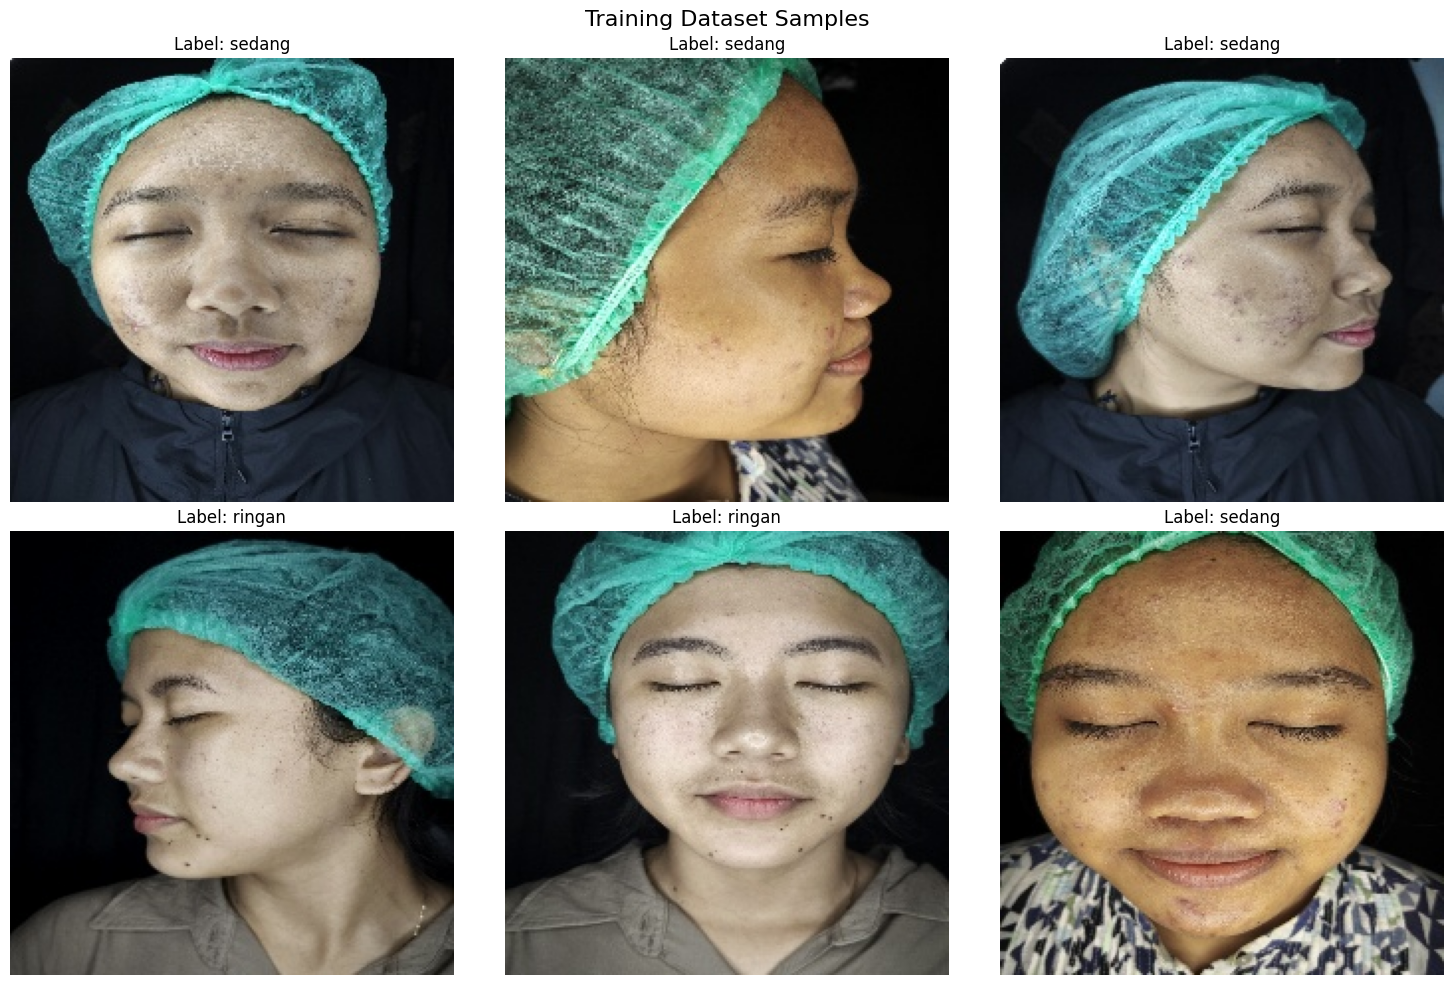


Validation Dataset Samples:


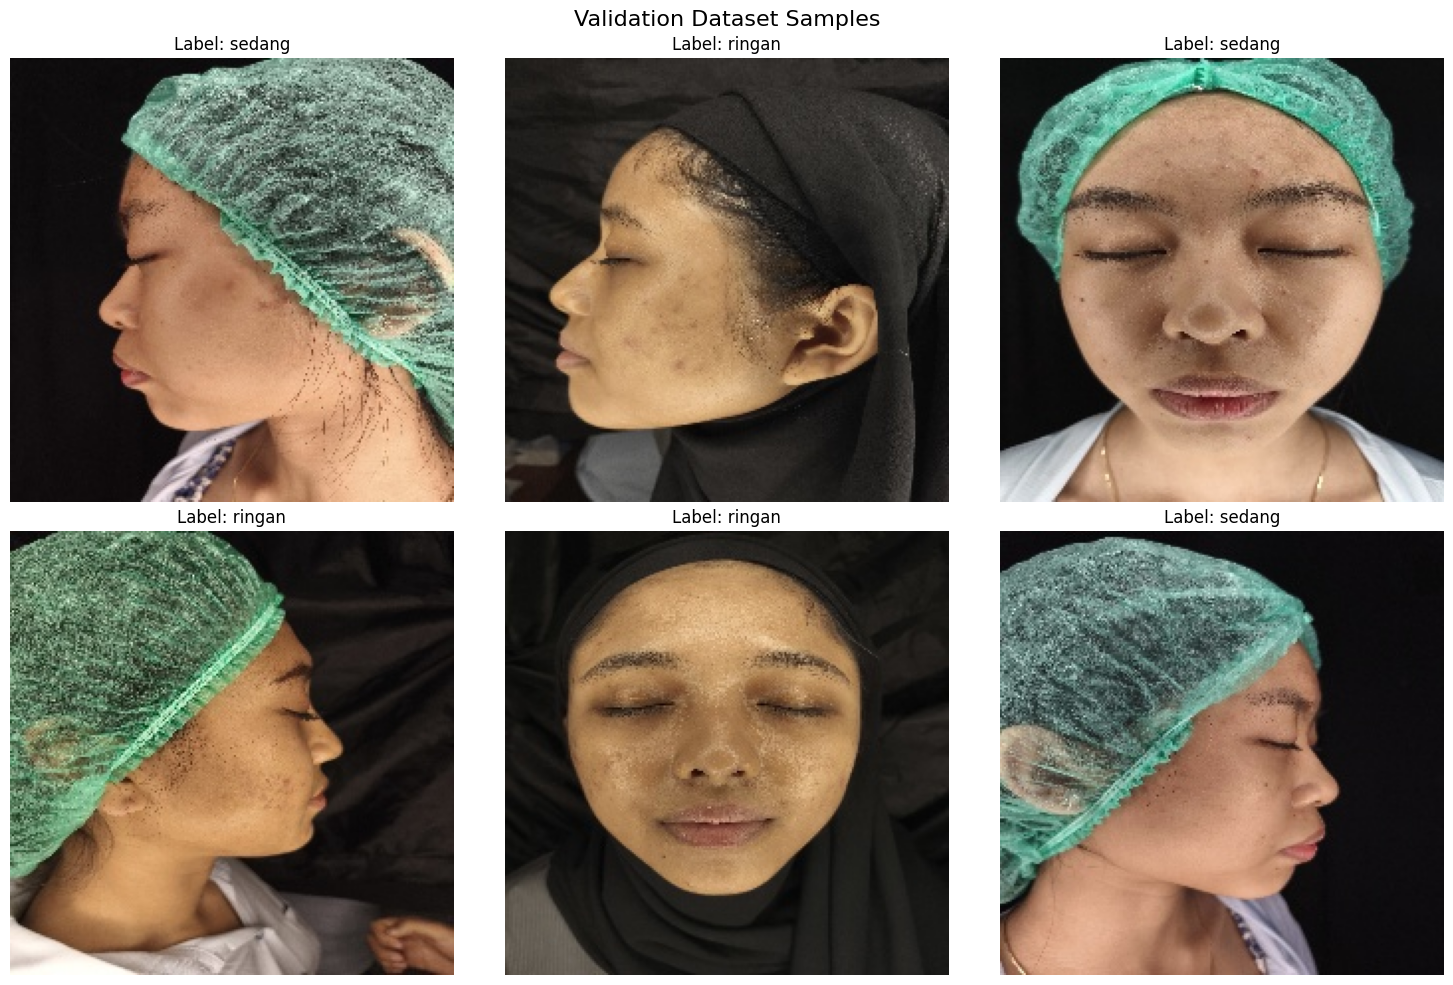

In [ ]:
print("\nTraining Dataset Samples:")
visualize_classification_samples(
    base_dir=f'{base_path}/train',
    num_samples=6,
    title="Training Dataset Samples"
)

print("\nValidation Dataset Samples:")
visualize_classification_samples(
    base_dir=f'{base_path}/val',
    num_samples=6,
    title="Validation Dataset Samples"
)

In [ ]:
# data_yaml = {
#     'path': base_path,
#     'train': 'train',
#     'val': 'val',
#     'names': {
#         0: 'ringan',
#         1: 'sedang'
#     }
# }

# yaml_path = f'{base_path}/data.yaml'
# with open(yaml_path, 'w') as f:
#     yaml.dump(data_yaml, f, sort_keys=False)

# print(f"\nDataset configuration saved to: {yaml_path}")

In [ ]:
model = YOLO("yolov8m-cls.pt")

In [ ]:
results = model.train(
    data="/content/acne_classification",
    epochs=200,
    imgsz=224,
    batch=16,
    device=0,
    project="acne_classification",
    name="yolov8_cls_medical",
    optimizer="AdamW",
    lr0=0.0005,
    weight_decay=0.0005,
    patience=40,
    pretrained=True,
    verbose=True
)

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/acne_classification, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_cls_medical, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=40, perspective=0.0, p

In [ ]:
# Validate the model
metrics = model.val(
    data="/content/acne_classification"
)

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8m-cls summary (fused): 42 layers, 15,765,218 parameters, 0 gradients, 41.6 GFLOPs
train: /content/acne_classification/train... found 29 images in 2 classes ✅ 
val: /content/acne_classification/val... found 7 images in 2 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 647.6±244.1 MB/s, size: 20.8 KB)
val: Scanning /content/acne_classification/val... 7 images, 0 corrupt: 100% ━━━━━━━━━━━━ 7/7 9.4Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 1/1 5.8it/s 0.2s
                   all      0.571          1
Speed: 1.1ms preprocess, 21.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val


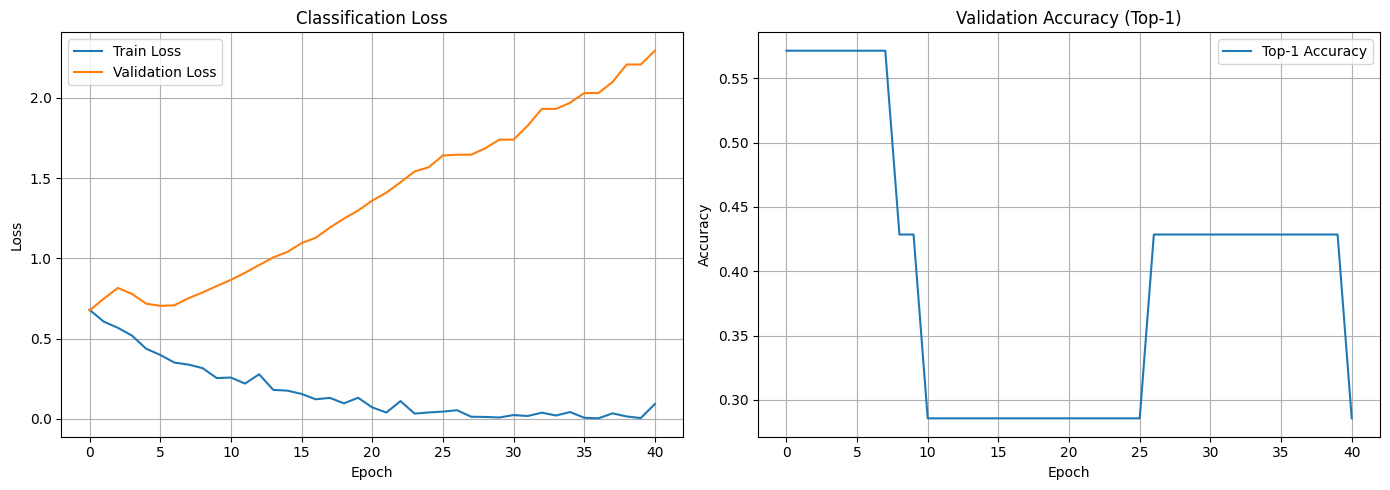

In [ ]:
def plot_training_results(project_path):
    """
    Plot training metrics for YOLO Classification
    """
    results_path = f'{project_path}/results.csv'

    if not os.path.exists(results_path):
        print(f"results.csv tidak ditemukan di {results_path}")
        return

    df = pd.read_csv(results_path)
    df.columns = df.columns.str.strip()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(df['train/loss'], label='Train Loss')
    axes[0].plot(df['val/loss'], label='Validation Loss')
    axes[0].set_title('Classification Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    if 'metrics/accuracy_top1' in df.columns:
        axes[1].plot(df['metrics/accuracy_top1'], label='Top-1 Accuracy')
        axes[1].set_title('Validation Accuracy (Top-1)')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True)
    else:
        axes[1].text(0.5, 0.5, 'Accuracy metric not found',
                     ha='center', va='center', fontsize=12)
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

plot_training_results(
    project_path='/content/acne_classification/yolov8_cls_medical/'
)

In [ ]:
!zip -r yolov8_result.zip /content/acne_classification/yolov8_cls_medical

  adding: content/acne_classification/yolov8_cls_medical/ (stored 0%)
  adding: content/acne_classification/yolov8_cls_medical/val_batch0_pred.jpg (deflated 4%)
  adding: content/acne_classification/yolov8_cls_medical/train_batch1.jpg (deflated 5%)
  adding: content/acne_classification/yolov8_cls_medical/results.png (deflated 9%)
  adding: content/acne_classification/yolov8_cls_medical/val_batch0_labels.jpg (deflated 4%)
  adding: content/acne_classification/yolov8_cls_medical/weights/ (stored 0%)
  adding: content/acne_classification/yolov8_cls_medical/weights/best.pt (deflated 8%)
  adding: content/acne_classification/yolov8_cls_medical/weights/last.pt (deflated 8%)
  adding: content/acne_classification/yolov8_cls_medical/train_batch0.jpg (deflated 3%)
  adding: content/acne_classification/yolov8_cls_medical/confusion_matrix_normalized.png (deflated 37%)
  adding: content/acne_classification/yolov8_cls_medical/results.csv (deflated 63%)
  adding: content/acne_classification/yolov8_cl

In [ ]:
!zip -r runs.zip /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/classify/ (stored 0%)
  adding: content/runs/classify/val/ (stored 0%)
  adding: content/runs/classify/val/val_batch0_pred.jpg (deflated 4%)
  adding: content/runs/classify/val/val_batch0_labels.jpg (deflated 4%)
  adding: content/runs/classify/val/confusion_matrix_normalized.png (deflated 37%)
  adding: content/runs/classify/val/confusion_matrix.png (deflated 36%)
